In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Hawkes Processes

## 1st method: Ogata

On va prendre une intensité initiale lambda = 1, et on ajoute e^(s-t) à chaque évènement

In [2]:
Tmax = 20
Lambda_init = 1

J'essaie de faire une fonction pour actualiser l'intensité du processus :

In [3]:
def jump(t,Time_jumps,n_jumps, Lambda_i): # Intensité du processus de Hawkes au temps t
    val = Lambda_i
    for j in range(0,n_jumps):
        if (t >= Time_jumps[j]):
            val += np.exp(-2*(t-Time_jumps[j]))
        if (t < Time_jumps[j]):
            return(val)
    return(val)

En utilisant le code du poisson inhomogène :

In [4]:
T = []
t = 0
i = 1
x = []
y = []
Lambda_Hawkes = Lambda_init
Lambda_bar = [Lambda_Hawkes]

while(t < Tmax):
    # Tirage d'un nouveau temps aléatoire, selon l'intensité modifiée
    t = t + np.random.exponential(1/Lambda_bar[-1])    

    if(t >= Tmax):# Si on dépasse le temps limite, fin de la boucle
        x.append(Tmax)
        #Lambda_bar.append(Lambda_bar[-1])
        break
    

    x.append(t)
    # On tire selon une loi uniforme pour faire une acceptation rejet
    u = np.random.uniform(0,1)
    y.append(u*Lambda_bar[-1])
    # On actualise l'intensité 
    Lambda_Hawkes = jump(t,T,len(T), Lambda_init)
    if(u <= Lambda_Hawkes/Lambda_bar[-1] ):
        T.append(t)
        Lambda_Hawkes = jump(t,T,len(T), Lambda_init)
    Lambda_bar.append(Lambda_Hawkes) 

In [5]:
jump_values = [jump(t, T, len(T), Lambda_init) for t in np.linspace(0,Tmax, 1000)]

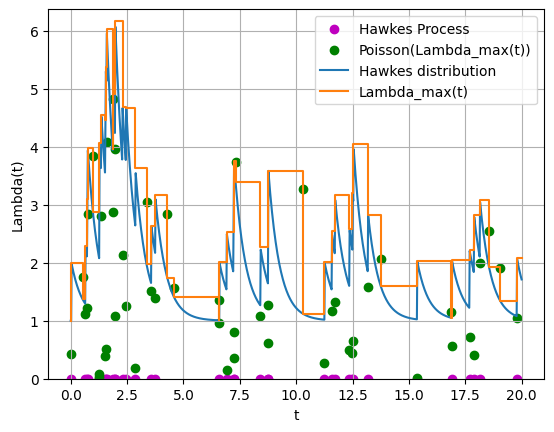

In [6]:
# Show plot
plt.grid(True)
plt.scatter(T, [0]*len(T), color='m', label='Hawkes Process')
plt.scatter(x[:-1], np.array(y), color='g', label='Poisson(Lambda_max(t))')
plt.plot(np.linspace(0, Tmax, 1000), jump_values, label='Hawkes distribution')
plt.ylim(0)
plt.step(x, Lambda_bar, where='pre', label='Lambda_max(t)')
plt.xlabel('t')
plt.ylabel('Lambda(t)')
plt.legend()
plt.grid(True)

# Save the plot as "hawkes_ogata.png"
plt.savefig('hawkes_ogata_int.png')


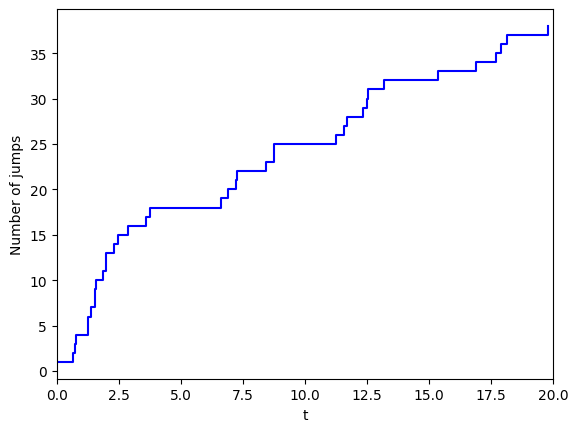

In [7]:
plt.step(T, np.arange(1, len(T) + 1), where='post', color='blue')
plt.xlim(0,Tmax)
plt.xlabel('t')
plt.ylabel('Number of jumps')
plt.savefig('hawkes_ogata.png')


## 2cd method: Superposition of Poisson Processes

Pour que ça fonctionne bien, il faut penser à vectoriser tout ça. Première étape : on tire le nombre d'évènements suivant une loi de Poisson de paramètre Lambda_0, et on répartit uniformément sur l'intervalle voulu. Pour chaque évènement, on va tirer la génération d'après : chaque individus aura un nombre d'enfant selon une lois de poisson de paramètre p (1/2 dans notre cas) sur l'intervalle restant. Chaque individu est ensuite distribué selon une loi exponentielle (qui apparait avec le choix de l'exponentielle négative, sinon distribué selon h/p). On boucle jusqu'à ce qu'il n'y ait plus d'enfants.

Following the construction given in article [1] :

In [8]:
immigrants = np.random.poisson(Lambda_init * Tmax)
hawkes = np.sort(np.random.uniform(0, Tmax, immigrants))
print("Nombre d'immigrants : " + str(immigrants))
times = hawkes
i = 1

while len(times) != 0:
    # We first get the number of childs for each individual
    num_childs = [np.random.poisson(0.5) for root in times] 
    print("Nombre d'individus de la génération " + str(i) + " : " + str(len(times)))
    # end condition
    if(num_childs == [0]*len(times)):
        break
    
    # We remove individuals without childs
    times = [times[i] for i in range(len(times)) if num_childs[i] > 0]
    num_childs = [num_childs[i] for i in range(len(num_childs)) if num_childs[i] > 0]
    
    # We then create the next generation time vector
    times = [times[j] + np.random.exponential(1/2) for j in range(len(times)) for i in range(num_childs[j])] 
    
    times = [val for val in times if val < Tmax]
    
    # We finally update the Hawkes vector 
    hawkes = np.append(hawkes, times) 
    i = i+1
hawkes = np.sort(hawkes)

Nombre d'immigrants : 16
Nombre d'individus de la génération 1 : 16
Nombre d'individus de la génération 2 : 9
Nombre d'individus de la génération 3 : 3
Nombre d'individus de la génération 4 : 2


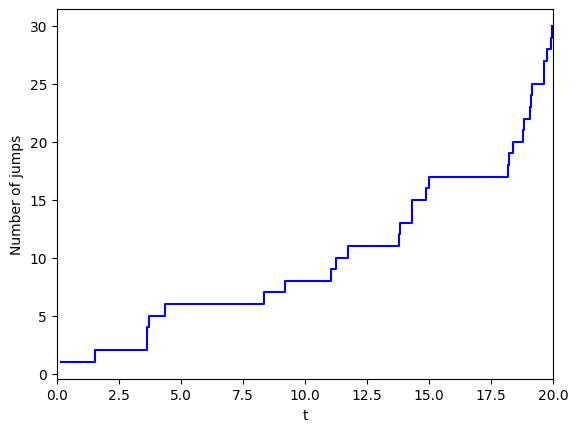

In [9]:
plt.step(hawkes, np.arange(1, len(hawkes) + 1), where='post', color='blue')
plt.xlim(0,Tmax)
plt.xlabel('t')
plt.ylabel('Number of jumps')
plt.savefig('hawkes_second_method.png')

En faisant apparaitre les clusters :

In [10]:
immigrants = np.random.poisson(Lambda_init * Tmax)
hawkes = np.sort(np.random.uniform(0, Tmax, immigrants))
print("Nombre d'immigrants : " + str(immigrants))
times = hawkes
i = 1
cluster = [j for j in range(len(hawkes))]
next_gen = cluster
gen = [0 for j in range(len(next_gen))]

while len(times) != 0:
    # We first get the number of childs for each individual
    num_childs = [np.random.poisson(0.5) for root in times] 
    print("Nombre d'individus de la génération " + str(i) + " : " + str(len(times)))
    # end condition
    if(num_childs == [0]*len(times)):
        break

    next_gen = [next_gen[w] for w in range(len(next_gen)) for k in range(num_childs[w]) if num_childs[w] > 0]
    
    # We remove individuals without childs
    times = [times[u] for u in range(len(times)) if num_childs[u] > 0]
    num_childs = [num_childs[v] for v in range(len(num_childs)) if num_childs[v] > 0]
    # We then create the next generation time vector
    times = [times[j] + np.random.exponential(1/2) for j in range(len(times)) for k in range(num_childs[j])] 
    
    times = [val for val in times if val < Tmax]
    
    # We finally update the Hawkes vector 
    hawkes = np.append(hawkes, times) 
    cluster = np.append(cluster, next_gen)
    gen = np.append(gen, [i for j in range(len(next_gen))])
    i = i+1

import pandas as pd

# Create a dictionary with the data
data = {'hawkes': hawkes, 'cluster': cluster, 'generation': gen}

df = pd.DataFrame(data)

# Sort the dataframe based on the 'hawkes' column
df_sorted = df.sort_values('hawkes')

# Print the sorted dataframe
print(df_sorted)

hawkes = np.sort(hawkes)
print(len(hawkes))
print(cluster)

Nombre d'immigrants : 19
Nombre d'individus de la génération 1 : 19
Nombre d'individus de la génération 2 : 3
Nombre d'individus de la génération 3 : 2
Nombre d'individus de la génération 4 : 1
       hawkes  cluster  generation
0    1.089761        0           0
1    1.774906        1           0
2    2.257302        2           0
3    2.985719        3           0
4    7.273409        4           0
5    7.780467        5           0
6    7.991977        6           0
19   8.141175        5           1
22   8.242661        5           2
20   8.348654        6           1
7    8.371752        7           0
8    8.736805        8           0
9    8.764968        9           0
21   8.777098        8           1
24   9.130444        5           3
23   9.289571        8           2
10  10.134410       10           0
11  13.848320       11           0
12  14.103932       12           0
13  15.603125       13           0
14  16.011265       14           0
15  16.336346       15           0
1

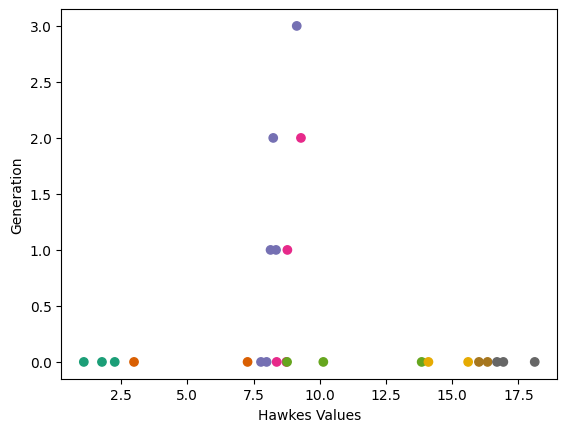

In [11]:
import matplotlib.pyplot as plt

# Plot the dots with different colors based on the cluster values
plt.scatter(df_sorted['hawkes'], df_sorted['generation'], c=df_sorted['cluster'], cmap='Dark2')

# Set the labels for x and y axes
plt.xlabel('Hawkes Values')
plt.ylabel('Generation')

# Show the plot
plt.show()